In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import pkg_resources
import pandas as pd
from astropy.constants import c
from astropy.coordinates import Distance
from pathlib import Path
from astropy.table import Table
from agnpy.emission_regions import Blob
from pytictoc import TicToc
t = TicToc()

%matplotlib widget

# import agnpy classes
import agnpy
from agnpy.spectra import BrokenPowerLaw
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton
from agnpy.utils.plot import load_mpl_rc, sed_x_label, sed_y_label, plot_sed

load_mpl_rc()

# import sherpa classes
from sherpa.models import model
from sherpa import data
from sherpa.fit import Fit
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar

from AgnpySSC import AgnpySSC


In [2]:
#######################################################################################################
### read data
#######################################################################################################
# Mrk 421 (J1104+3812)
source = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/Mrk421_example.csv') 
freq = source['freq'].values
flux = source['flux'].values
flux_err = source['flux_err'].values
#Sourcename = 'Mrk 421'

# My source #J2158-3013
#filename = '/Users/87steven/Documents/ASIAA/Blazar SED code and data/source individual flux/J1104+3812_flux.csv'

#filename = '/Users/87steven/Documents/ASIAA/Blazar SED code and data/source individual flux/J2158-3013_flux.csv'
#source = pd.read_csv(filename) 
#Sourcename = filename[80:90]

freq = source['freq'].values
flux = source['flux'].values
flux_err = source['flux_err'].values

### set flux error which is nan to 0.01
fluxerr_nan = np.where( np.isnan(flux_err ))[0]
flux_err[fluxerr_nan] = 0.01
### find flux index which is not nan
flux_NOTnan = np.where( (~np.isnan(flux)) & (flux > 0) )[0]
### save new data into array
freq = freq[flux_NOTnan]
flux = flux[flux_NOTnan]
flux_err = flux_err[flux_NOTnan]

#freq = np.append(freq, freq_example)
#flux = np.append(flux, flux_example )
#flux_err = np.append(flux_err, flux_err_example)

#######################################################################################################
### check read in data
#######################################################################################################
#plt.rcParams['figure.figsize'] = [6, 4.5]
#plt.rcParams['axes.linewidth'] = 3
    
#fig, ax = plt.subplots()

#ax.plot(np.log10(freq), np.log10(flux), '.', color = 'red', label = 'Total SED')
#ax.errorbar(np.log10(freq), np.log10(flux), yerr = flux_err, marker=".", color = "red", ecolor = "red", linestyle = '') 

#ax.set_xlim (7, 29)
#ax.set_ylim (-16, -7) 

#plt.legend(loc = 'upper left', shadow = True, fontsize = 8, markerscale = 1) 

#plt.xlabel( "log($\\nu$) [Hz]",  fontsize = 12)
#plt.xticks(fontsize = 8)
#plt.ylabel('log($\\nu$ F($\\nu$)) [erg $\mathrm{cm^{-2}\ s^{-1}}$]',  fontsize = 10)
#plt.yticks(fontsize = 8)
#plt.grid(True)
#figurename = 'J1256-0547 SED Test'
#plt.title(figurename, fontsize = 16)
#######################################################################################################
### systematic errors
#######################################################################################################
# array of systematic errors, will just be summed in quadrature to the statistical error
# we assume
# - 30% on VHE gamma-ray instruments
# - 10% on HE gamma-ray instruments
# - 10% on X-ray instruments
# - 5% on lower-energy instruments

### define energy ranges
nu_vhe = 2.42E25 # [Hz]
nu_he = 2.42E22 # [Hz]
nu_x_ray_max = 4.25E19 # [Hz]
nu_x_ray_min = 7.25E16 # [Hz]
vhe_gamma = freq >= nu_vhe
he_gamma = (freq >= nu_he) * (freq  < nu_vhe)
x_ray = (freq  >= nu_x_ray_min) * (freq  < nu_x_ray_max)
uv_to_radio = freq  < nu_x_ray_min

### declare systematics
y_err_syst = np.zeros(len(freq ))
y_err_syst[vhe_gamma] = 0.30
y_err_syst[he_gamma] = 0.10
y_err_syst[x_ray] = 0.10
y_err_syst[uv_to_radio] = 0.05
y_err_syst = flux * y_err_syst

### Constrain flux range
#index = np.where(freq <= 1.0E19)[0]

#freq = freq[index]
#flux = flux[index]
#flux_err = flux_err[index]
#y_err_syst = y_err_syst[index]

# define the data1D object containing it
sed = data.Data1D("sed", freq, flux, staterror = flux_err, syserror = y_err_syst)  # 


Model fit succesful?? True
Elapsed time is 12.263488 seconds.
Model fit Parameters
Method                = levmar
Statistic             = chi2
Initial fit statistic = 4228.07
Final fit statistic   = 1157.39 at function evaluation 59
Data points           = 105
Degrees of freedom    = 99
Probability [Q-value] = 5.68059e-180
Reduced statistic     = 11.6908
Change in statistic   = 3070.67
   ssc.log10_k_e   -8.17101     +/- 0.0762613   
   ssc.p1         2.14269      +/- 0.0152312   
   ssc.p2         3.35848      +/- 0.0588692   
   ssc.log10_gamma_b   5.05026      +/- 0.0284167   
   ssc.delta_D    22.7687      +/- 0.603458    
   ssc.log10_B    -1.5237      +/- 0.0319903   
Emission Parameters
* spherical emission region
 - R_b (radius of the blob): 5.72e+16 cm
 - t_var (variability time scale): 1.00e+00 d
 - V_b (volume of the blob): 7.84e+50 cm3
 - z (source redshift): 0.03
 - d_L (source luminosity distance):4.34e+26 cm
 - delta_D (blob Doppler factor): 2.28e+01
 - Gamma (blob Loren

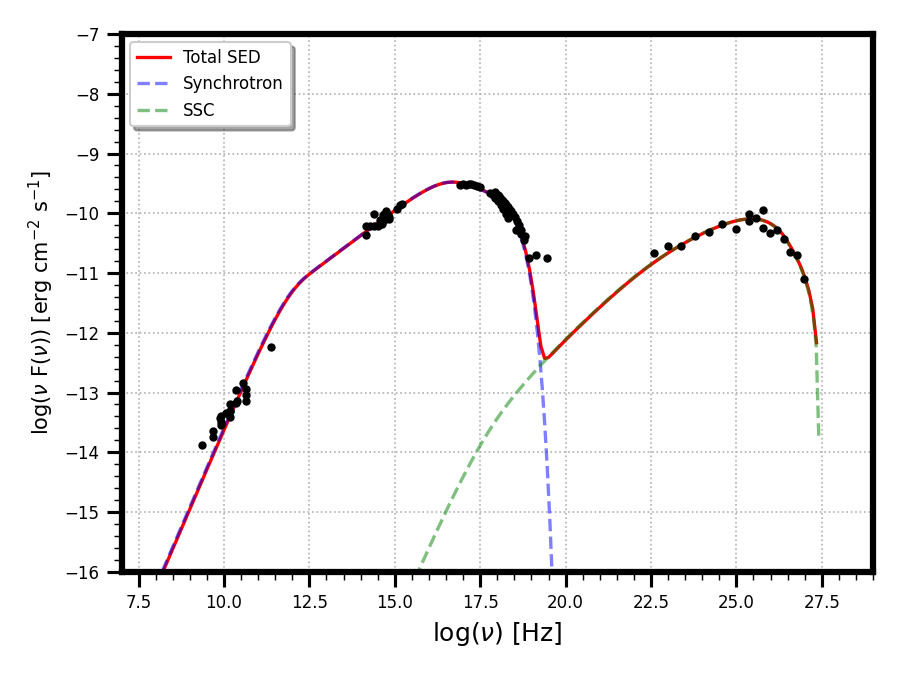

In [6]:
#######################################################################################################
### find frequency of maximum flux between 1.0E12 ~ 1.0E20
#######################################################################################################
index = np.where((freq > 1.0E12) & (freq <= 1.0E20))[0]

max_flux_index = np.where(flux == max(flux[index]))[0]

min_flux_freq = freq[0]
max_flux_freq = freq[max_flux_index][0]

#######################################################################################################
# declare parameters
#######################################################################################################
agnpy_ssc = AgnpySSC()
# initialise parameters (parameters from Table 4 and Figure 11 of Abdo 2011)
z = 0.031                            # redshift (0.0308)
d_L = Distance(z=z).to("cm")          # luminosity distance [cm]
delta_D = 18                          # doppler factor (free parameter) (18)
log10_B = np.log10(0.05)              # magnetic field sterength [G] (free parameter) (-1.3 = np.log10(0.05))
t_var = 60*60*24                      # variability timescale [sec] (60*60*24)
log10_k_e = np.log10(1.26E-8)         # (-7.9 = np.log10(1.26E-8))
p1 = 2.02                             # electron distribution index = 2*(spectral index)+1 (2.02)
p2 = 3.43                             # electron distribution index = 2*(spectral index)+1 (3.43)

gamma_b_min = 500
gamma_b_break = 1.0E5

log10_gamma_b = np.log10(gamma_b_break)       # lorentz break factor (5 = np.log10(1.0E5))
log10_gamma_min = np.log10(gamma_b_min)       # minimum lorentz factor (500)
log10_gamma_max = np.log10(gamma_b_break*10)     # maximum lorentz factor (1.0E6)

R_b = c*t_var*delta_D/(1+z)*100       # radius [cm] ====> Doppler factor is include in here (5.2E16 )

#######################################################################################################
# enter parameters into model
#######################################################################################################
# - AGN parameters
agnpy_ssc.z = z                      # redshift 
agnpy_ssc.z.freeze()
agnpy_ssc.d_L = d_L                  # luminosity distance [cgs]
agnpy_ssc.d_L.freeze()
# - blob parameters
agnpy_ssc.delta_D = delta_D          # doppler factor (free parameter)
agnpy_ssc.log10_B = log10_B          # magnetic field sterength [G] (free parameter)
agnpy_ssc.t_var = t_var              # variability timescale [sec]
agnpy_ssc.t_var.freeze()
# - EED
agnpy_ssc.log10_k_e = log10_k_e      # opacity
agnpy_ssc.p1 = p1                    # spectral index
agnpy_ssc.p2 = p2                    # spectral index
agnpy_ssc.log10_gamma_b = log10_gamma_b       # lorentz break factor
agnpy_ssc.log10_gamma_min = log10_gamma_min   # minimum lorentz factor
agnpy_ssc.log10_gamma_min.freeze()
agnpy_ssc.log10_gamma_max = log10_gamma_max   # maximum lorentz factor
agnpy_ssc.log10_gamma_max.freeze()

#######################################################################################################
### fit using the Levenberg-Marquardt optimiser
#######################################################################################################
fitter = Fit(sed, agnpy_ssc, stat = Chi2(), method = LevMar())
# Set minimum and maximum frequency to proced model fit
min_x = 1.0E8
max_x = 1.0E30
sed.notice(min_x, max_x)

t.tic()
#######################################################################################################
### perform model fit
#######################################################################################################
result = fitter.fit()
print("Model fit succesful??", result.succeeded)
t.toc()
print('=================================================')
print("Model fit Parameters")
print(result.format())

#######################################################################################################
### define the emission region parameters
#######################################################################################################
k_e = 10**agnpy_ssc.log10_k_e.val                    
p1 = agnpy_ssc.p1.val                            
p2 = agnpy_ssc.p2.val                            
gamma_b = 10**agnpy_ssc.log10_gamma_b.val        
gamma_min = 10**agnpy_ssc.log10_gamma_min.val    
gamma_max = 10**agnpy_ssc.log10_gamma_max.val    
B = 10**agnpy_ssc.log10_B.val                        
delta_D = agnpy_ssc.delta_D.val                  
R_b = ( c.value*t_var*agnpy_ssc.delta_D/(1+agnpy_ssc.z) ).val*100    

parameters = {
    "p1": p1,
    "p2": p2,
    "gamma_b": gamma_b,
    "gamma_min": gamma_min,
    "gamma_max": gamma_max,
}

spectrum_dict = {"type": "BrokenPowerLaw", "parameters": parameters}

blob = Blob(R_b*u.cm, z, delta_D, delta_D, B*u.G, k_e*u.cm**-3, spectrum_dict, spectrum_norm_type = "differential")
print('=================================================')
print("Emission Parameters")
print('=================================================')
print(blob)
print(f"jet power in particles: {blob.P_jet_e:.2e}")
print(f"jet power in B: {blob.P_jet_B:.2e}")

#######################################################################################################
### insert parameters into model and do model fit
#######################################################################################################
# define the radiative processes
synch = Synchrotron(blob)
ssc = SynchrotronSelfCompton(blob)
# make a finer grid to compute the SED
nu = np.logspace(8, 30, 300) * u.Hz
synch_sed = synch.sed_flux(nu)
ssc_sed = ssc.sed_flux(nu)
#######################################################################################################
### plot SED and deconposed conponents
#######################################################################################################
# put fitted parameters into array
data_x = sed.x
data_y = sed.y
y_err_lin = sed.get_error()
# use for test source Mrk 421
#data_y_err = 0.434*y_err_lin/data_y  # relative error in log scale
# use for other sources
data_y_err = y_err_lin

fit_x = np.logspace(np.log10(min_x), np.log10(max_x), 200)
fit_y = agnpy_ssc(fit_x).to_value()

# decomposed parameters into array
x = ( nu/(1+z) ).value
syn_y = synch_sed.value
ssc_y = ssc_sed.value

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams['axes.linewidth'] = 3
    
fig, ax = plt.subplots()

ax.plot(np.log10(fit_x), np.log10(fit_y), '-', color = 'red', label = 'Total SED')
ax.errorbar(np.log10(data_x), np.log10(data_y), yerr = data_y_err, marker=".", color = "black", ecolor = "black", linestyle = '') 

#ax.plot(np.log10(x), np.log10(syn_y+ssc_y), '--', color = 'orange', label = 'Synchrotron+SSC')
ax.plot(np.log10(x), np.log10(syn_y), '--', color = 'blue', alpha = 0.5, label = 'Synchrotron')
ax.plot(np.log10(x), np.log10(ssc_y), '--', color = 'green', alpha = 0.5, label = 'SSC')

ax.set_xlim (7, 29)
ax.set_ylim (-16, -7) 

plt.legend(loc = 'upper left', shadow = True, fontsize = 8, markerscale = 1) 

plt.xlabel( "log($\\nu$) [Hz]",  fontsize = 12)
plt.xticks(fontsize = 8)
plt.ylabel('log($\\nu$ F($\\nu$)) [erg $\mathrm{cm^{-2}\ s^{-1}}$]',  fontsize = 10)
plt.yticks(fontsize = 8)
plt.grid(True)
#figurename = Sourcename+' SED Fitting ($\\chi^2$ = %4.2E)' %(float(result.rstat))
#plt.title(figurename, fontsize = 16)


In [ ]:
#######################################################################################################
### define the emission region parameters
#######################################################################################################
agnpy_ssc = AgnpySSC()

z = 0.031
k_e = 1.26E-8                 
p1 = 2.8                            
p2 = 2.8
gamma_b = 189206   
gamma_min = 11 
gamma_max = 18920647
B = 0.3
delta_D = 54       
t_var = 60*60*7
R_b = 3.96E16
#R_b = ( c.value*t_var*agnpy_ssc.delta_D/(1+agnpy_ssc.z) ).val*100 

parameters = {
    "p1": p1,
    "p2": p2,
    "gamma_b": gamma_b,
    "gamma_min": gamma_min,
    "gamma_max": gamma_max,
}

spectrum_dict = {"type": "BrokenPowerLaw", "parameters": parameters}

blob = Blob(R_b*u.cm, z, delta_D, delta_D, B*u.G, k_e*u.cm**-3, spectrum_dict, spectrum_norm_type = "differential")
print('=================================================')
print("Emission Parameters")
print('=================================================')
print(blob)
print(f"jet power in particles: {blob.P_jet_e:.2e}")
print(f"jet power in B: {blob.P_jet_B:.2e}")

#######################################################################################################
### insert parameters into model and do model fit
#######################################################################################################
# define the radiative processes
synch = Synchrotron(blob)
ssc = SynchrotronSelfCompton(blob)
# make a finer grid to compute the SED
nu = np.logspace(8, 30, 300) * u.Hz
synch_sed = synch.sed_flux(nu)
ssc_sed = ssc.sed_flux(nu)
#######################################################################################################
### plot SED and deconposed conponents
#######################################################################################################
# put fitted parameters into array
data_x = sed.x
data_y = sed.y
y_err_lin = sed.get_error()
# use for test source Mrk 421
#data_y_err = 0.434*y_err_lin/data_y  # relative error in log scale
# use for other sources
data_y_err = y_err_lin

min_x = 1.0E8
max_x = 1.0E30

fit_x = np.logspace(np.log10(min_x), np.log10(max_x), 200)
fit_y = agnpy_ssc(fit_x).to_value()

# decomposed parameters into array
x = ( nu/(1+z) ).value
syn_y = synch_sed.value
ssc_y = ssc_sed.value

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams['axes.linewidth'] = 3
    
fig, ax = plt.subplots()

ax.plot(np.log10(fit_x), np.log10(fit_y), '-', color = 'red', label = 'Total SED')
ax.errorbar(np.log10(data_x), np.log10(data_y), yerr = data_y_err, marker=".", color = "black", ecolor = "black", linestyle = '') 

ax.plot(np.log10(x), np.log10(syn_y+ssc_y), '--', color = 'orange', label = 'Synchrotron+SSC')
ax.plot(np.log10(x), np.log10(syn_y), '--', color = 'blue', alpha = 0.5, label = 'Synchrotron')
ax.plot(np.log10(x), np.log10(ssc_y), '--', color = 'green', alpha = 0.5, label = 'SSC')

ax.set_xlim (7, 29)
ax.set_ylim (-16, -7) 

plt.legend(loc = 'upper left', shadow = True, fontsize = 8, markerscale = 1) 

plt.xlabel( "log($\\nu$) [Hz]",  fontsize = 12)
plt.xticks(fontsize = 8)
plt.ylabel('log($\\nu$ F($\\nu$)) [erg $\mathrm{cm^{-2}\ s^{-1}}$]',  fontsize = 10)
plt.yticks(fontsize = 8)
plt.grid(True)
figurename = 'Mrk 421 SED Fitting ($\\chi^2$ = %4.2E)' %(float(result.rstat))
plt.title(figurename, fontsize = 16)

In [ ]:
#######################################################################################################
### save SED file into csv form
#######################################################################################################
import pandas as pd

def ClearData():
    data = {
    'freq': [],
    'flux': [],
    'flux_err': []
      }
    return data

df = ClearData()

# read the 1D data
sed_path = pkg_resources.resource_filename("agnpy", "data/mwl_seds/Mrk421_2011.ecsv")
sed_table = Table.read(sed_path)

for i in range(0, len(sed_table)):
    df['freq'].append(sed_table[i][0]/4.13E-15)
    df['flux'].append(sed_table[i][1])
    df['flux_err'].append(sed_table[i][2])

CSVfile = f'/Users/87steven/Documents/ASIAA/Blazar SED code and data/Mrk421_example.csv'   
dff = pd.DataFrame(df)      
dff.to_csv(CSVfile, index = False)